In [1]:
import xarray as xr
import pandas as pd
from utilities.plotting import *
from utilities.utils import *

In [2]:
gas_costs=[10, 25, 50, 100, 250, 500, 750, 1000, 2500, 7500, 10000]
countries = ['United States of America', 'Germany', 'China', 'Saudi Arabia']
colors = sns.color_palette("rocket", as_cmap=True)(np.linspace(0, 1, int(len(countries))+1))
case = 'CSP_storage'

/central/groups/carnegie_poc/awongel/clab_concentrated_solar/utilities/utils.py:232: RuntimeWarning: Mean of empty slice
  add_to_df['mean cs fraction'] = [np.nanmean(cs_frac_country['value'].values) for cs_frac_country in cs_frac_countries]
/home/awongel/miniconda3/envs/table_pypsa_env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/central/groups/carnegie_poc/awongel/clab_concentrated_solar/utilities/utils.py:234: RuntimeWarning: All-NaN slice encountered
  add_to_df['median cs fraction'] = [np.nanmedian(cs_frac_country['value'].values) for cs_frac_country in cs_frac_countries]
/home/awongel/miniconda3/envs/table_pypsa_env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/central/groups/carnegie_poc/awongel/clab_concentrated_solar/utilities/utils.py:232: RuntimeWarning: Mea

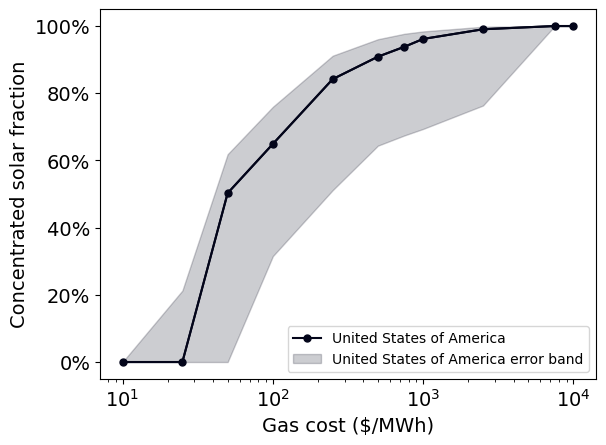

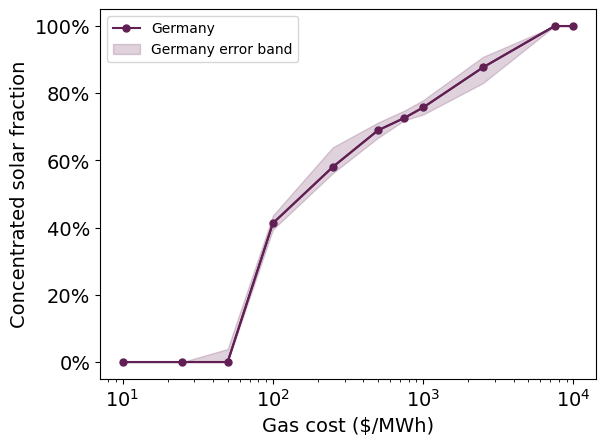

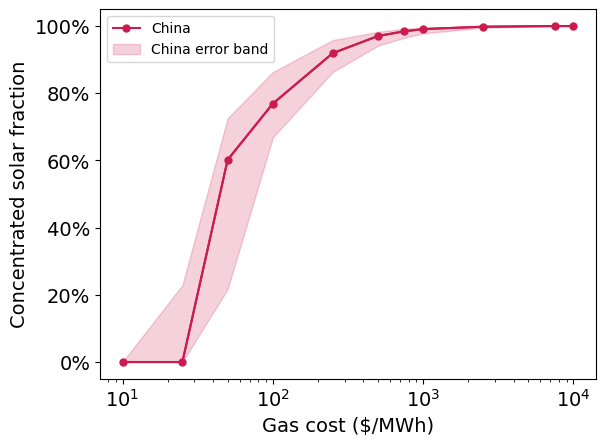

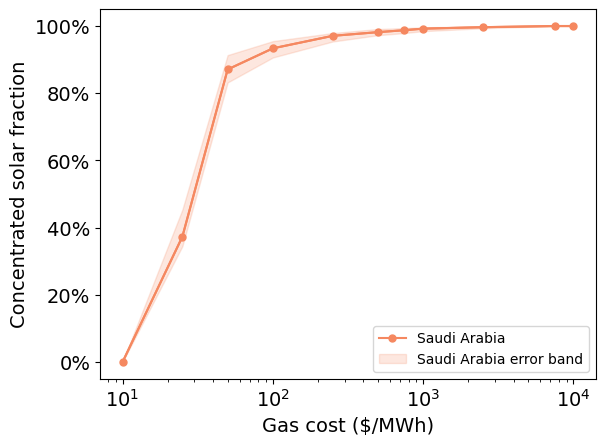

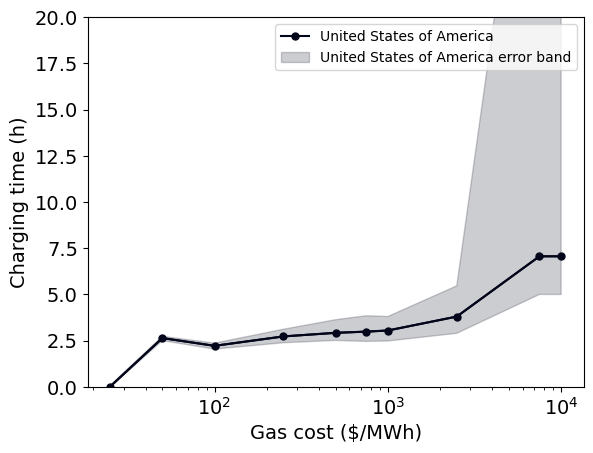

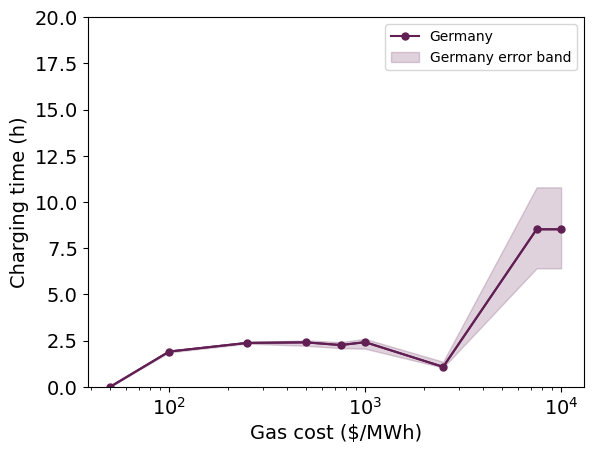

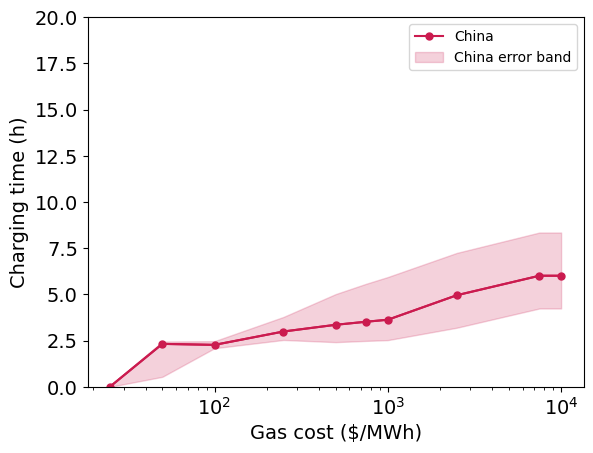

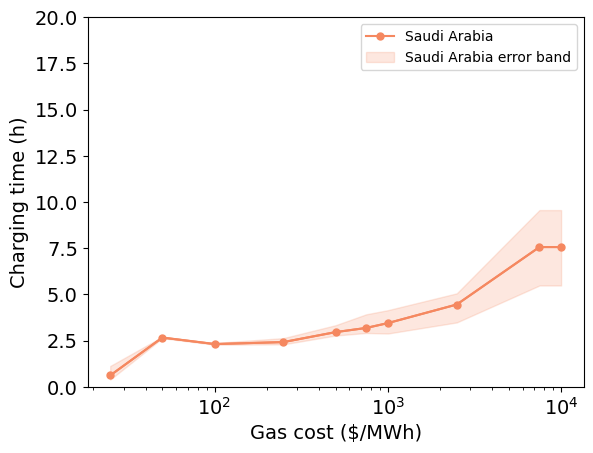

In [ ]:

for var in ['cs_fraction', 'storage_ratio']:
    latitude_df = pd.DataFrame()
    for gas_cost in gas_costs:
        masked_dataset = mask_data_region(xr.open_dataset(f'output_data/{var}_{case}_gas{gas_cost}.nc'), get_world())
        latitude_df = calculate_country_mean(latitude_df, masked_dataset, countries, gas_cost)

    for ic,country in enumerate(countries):
        plot_line(latitude_df, country, colors[ic], var)
        if var == 'cs_fraction':
            plot_marginal_abatement_cost(latitude_df)

In [4]:
# for gas_cost in [25, 100, 1000]:
#     plot_result_map(f'output_data/cs_fraction_CSP_storage_gas{gas_cost}.nc', 'CSP_storage', f'Gas cost = ${gas_cost}/MWh', 'Concentrated solar fraction')

In [5]:
# for frac_threshold in ['0p25', '0p5', '0p75']:
    # plot_result_map(f'output_data/gas_price_min_frac_CSP_storage_threshold{frac_threshold}.nc', 'CSP_storage', f'Concentrated solar thermal fraction >{float(frac_threshold.replace("p","."))*100}%', 'Gas fuel price ($/MWh)')